In [1]:
%matplotlib inline
import os
import nibabel as nib
from nilearn import datasets, plotting, image
from scipy import stats

In [2]:
path='/Users/kasia/Documents/Topology/101309_ses-1/motion_correct/_scan_func-1/'
epi=os.path.join(path, 'tfMRI_WM_LR_calc_resample_volreg.nii.gz')
epi2=nib.load(epi)

#path2='/Volumes/Disc2/Anat/100307/MNINonLinear/'


#movement='/Users/kasia/Documents/Topology/100307_preproc/MNINonLinear/Results/tfMRI_WM_LR/Movement_Regressors.txt'

We use probabilistic regions of interest (ROIs) from the MSDL atlas.



In [3]:
func_filename=epi2

from nilearn import input_data

power = datasets.fetch_coords_power_2011()
print('Power atlas comes with {0}.'.format(power.keys()))

import numpy as np

coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

print('Stacked power coordinates in array of shape {0}.'.format(coords.shape))

spheres_masker = input_data.NiftiSpheresMasker(
    smoothing_fwhm=4, seeds=coords, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=0.72)


#WM_confounds = image.high_variance_confounds(epi, mask_img="mask_WM.nii.gz")
#CSF_confounds = image.high_variance_confounds(epi, mask_img="mask_CSF.nii.gz")

timeseries = spheres_masker.fit_transform(func_filename)

Power atlas comes with dict_keys(['rois', 'description']).
Stacked power coordinates in array of shape (264, 3).


In [4]:
np.save('ts_5.npy',timeseries)

In [5]:
np.savez('out5.npz', timeseries)

import scipy.io as sio
sio.savemat('t5.mat', mdict={'t1': timeseries})

In [6]:
w=60
o=30

windows=[]
derivative=[]
    
    
def frange(start, stop, step=1.0):
    ''' "range()" like function which accept float type''' 
    i = start
    while i < stop:
        yield i
        i += step
 

        
for i in frange(0, 345, 30):
    print(i)   # Use generated element
    strip=timeseries[i:i+w,:]
    R1 = np.corrcoef(strip.T)
    #R1=stats.zscore(R1)
    #np.fill_diagonal(R1, 0)
    R2=np.diff(R1)
    R1[R1<=0]=np.inf
    R1[np.isfinite(R1)]=1/R1[np.isfinite(R1)]
    windows.append(R1)
    derivative.append(R2)
    
    
der=np.dstack(derivative)
win=np.dstack(windows)

0
30
60
90
120
150
180
210
240
270
300
330


In [7]:
d=np.diff(win, axis=-1)

/Users/kasia/anaconda3/envs/dyneusr/lib/python3.7/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [8]:
win[~np.isfinite(win)]=np.max(win[np.isfinite(win)])

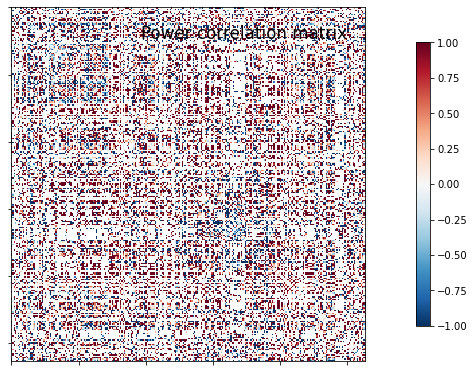

In [9]:
# Mask the main diagonal for visualization:
#np.fill_diagonal(der[:,:,6], 0)


plotting.plot_matrix(d[:,:,0], vmin=-1, vmax=1, colorbar=True,
                     title='Power correlation matrix')

plotting.show()

In [10]:
from sklearn.cluster import AgglomerativeClustering

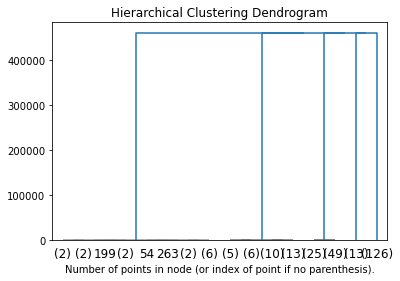

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = (win[:,:,6])
np.fill_diagonal(X, 0)
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, affinity='precomputed', linkage='complete',
                                n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [12]:
ordered_points=[child[0]for child in model.children_ if child[0]<win.shape[0]]

In [13]:
frame=win[:,:,0]

frame=frame[ordered_points][:,ordered_points]

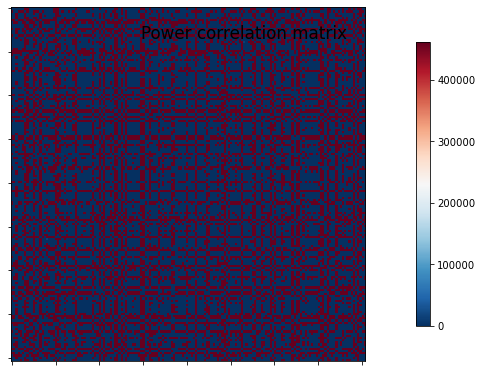

In [14]:
plotting.plot_matrix(frame, vmin=0, vmax=np.max(frame), colorbar=True,
                     title='Power correlation matrix')

plotting.show()